Importing required Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


Getting CIFAR10 dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


Plotting an image of each class using pyplot 

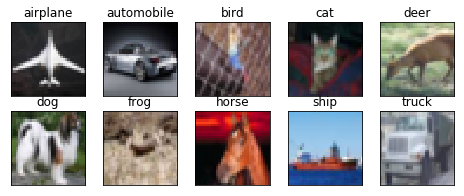

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Method to plot model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Method to get test accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## ENAS Model - Using Upsampling2D

In [0]:
# Using Upsampling2D

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, SeparableConv2D, UpSampling2D
from keras.layers.merge import concatenate


visible = Input(shape=(32,32,3)) 

x1 = SeparableConv2D(24, (5, 5), border_mode='same')(visible) #32, RF: 5
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.1)(x1)

# Convolution block

x2 = Convolution2D(48, 5, 5, border_mode='same')(x1) #32, RF: 
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.1)(x2)

x3 = Convolution2D(72, 5, 5, border_mode='same')(x2)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Dropout(0.1)(x3)

concat_x3_x1 = concatenate([x3, x1])
x4 = SeparableConv2D(128, (5, 5), border_mode='same')(concat_x3_x1)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.1)(x4)

# Trasition block
concat_x4_x1 = concatenate([x4, x1])
x5 = MaxPooling2D(pool_size=(2, 2))(concat_x4_x1)

# Convolution block
x6 = UpSampling2D(size=(2, 2), data_format="channels_last")(x5)

x6 = SeparableConv2D(24, (3, 3), border_mode='same')(x6)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = Dropout(0.1)(x6)

concat_x6_x4_x1 = concatenate([x6, x4, x1])
x7 = Convolution2D(48, 5, 5, border_mode='same')(concat_x6_x4_x1)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = Dropout(0.1)(x7)


concat_x7_x6_x4_x3 = concatenate([x7, x6, x4, x3])
x8 = SeparableConv2D(72, (3, 3), border_mode='same')(concat_x7_x6_x4_x3)
x8 = BatchNormalization()(x8)
x8 = Activation('relu')(x8)
x8 = Dropout(0.1)(x8)


concat_x8_x7_x6_x4_x3_x1 = concatenate([x8, x7, x6, x4, x3, x1])
x9 = SeparableConv2D(128, (5, 5), border_mode='same')(concat_x8_x7_x6_x4_x3_x1)
x9 = BatchNormalization()(x9)
x9 = Activation('relu')(x9)
x9 = Dropout(0.1)(x9)


# Trasition block
concat_x9_x8_x6_x4_x1 = concatenate([x9, x8, x6, x4, x1])
x10 = MaxPooling2D(pool_size=(2, 2))(concat_x9_x8_x6_x4_x1)

x10 = UpSampling2D(size=(2, 2), data_format="channels_last")(x10)

# Convolution block
concat_x10_x7 = concatenate([x10, x7])
x11 = Convolution2D(24, 5, 5, border_mode='same')(concat_x10_x7)
x11 = BatchNormalization()(x11)
x11 = Activation('relu')(x11)
x11 = Dropout(0.1)(x11)


concat_x11_x8_x2_x1 = concatenate([x11, x8, x2, x1])
x12 = SeparableConv2D(48, (5, 5), border_mode='same')(concat_x11_x8_x2_x1)
x12 = BatchNormalization()(x12)
x12 = Activation('relu')(x12)
x12 = Dropout(0.1)(x12)


concat_x12_x11_x6_x3_x2 = concatenate([x12, x11, x6, x3, x2])
x13 = Convolution2D(72, 3, 3, border_mode='same')(concat_x12_x11_x6_x3_x2)
x13 = BatchNormalization()(x13)
x13 = Activation('relu')(x13)
x13 = Dropout(0.1)(x13)


concat_x13_x12_x8_x6_x4_x3_x1 = concatenate([x13, x12, x8, x6, x4, x3, x1])
x14 = SeparableConv2D(128, (5, 5), border_mode='same')(concat_x13_x12_x8_x6_x4_x3_x1)
x14 = BatchNormalization()(x14)
x14 = Activation('relu')(x14)
x14 = Dropout(0.1)(x14)


x15 = Convolution2D(10, 1, 1)(x14)
last_layer = Convolution2D(10, 32, 32)(x15)

flat = Flatten()(last_layer)
output = Activation('softmax')(flat)

model = Model(inputs=visible, outputs=output)

print(model.summary())

W0619 03:08:42.043196 140341739652992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 03:08:42.080658 140341739652992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(24, (5, 5), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
W0619 03:08:42.088921 140341739652992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 03:08:42.138600 140341739652992 deprecation_w

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 24)   171         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

W0619 03:08:58.990066 140341739652992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Training the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0619 03:09:03.854578 140341739652992 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is depr

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 154s 395ms/step - loss: 1.7481 - acc: 0.4343 - val_loss: 1.8181 - val_acc: 0.4459
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 151s 388ms/step - loss: 1.3589 - acc: 0.5724 - val_loss: 14.3137 - val_acc: 0.1030
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 149s 381ms/step - loss: 1.1841 - acc: 0.6322 - val_loss: 1.1486 - val_acc: 0.6071
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 148s 380ms/step - loss: 1.0580 - acc: 0.6719 - val_loss: 1.1611 - val_acc: 0.6343
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 148s 380ms/step - loss: 0.97

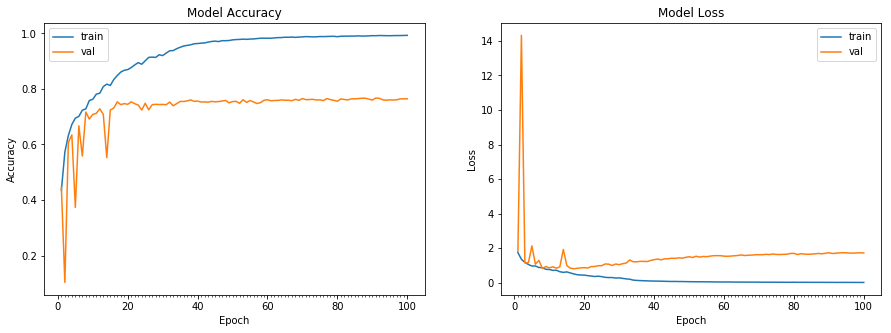

Accuracy on test data is: 76.47


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## ENAS Model - Using Conv2DTranspose

In [0]:
# Using Conv2DTranspose

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, SeparableConv2D, Conv2DTranspose
from keras.layers.merge import concatenate


visible = Input(shape=(32,32,3)) 

x1 = SeparableConv2D(24, (5, 5), border_mode='same')(visible)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.1)(x1)

x2 = Convolution2D(48, 5, 5, border_mode='same')(x1)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.1)(x2)

x3 = Convolution2D(72, 5, 5, border_mode='same')(x2)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Dropout(0.1)(x3)

concat_x3_x1 = concatenate([x3, x1])
x4 = SeparableConv2D(128, (5, 5), border_mode='same')(concat_x3_x1)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.1)(x4)

# Trasition block
concat_x4_x1 = concatenate([x4, x1])
x5 = MaxPooling2D(pool_size=(2, 2))(concat_x4_x1)

# Convolution block
x6 = Conv2DTranspose(24, (2, 2), strides=(2, 2), border_mode='same')(x5)

x6 = SeparableConv2D(24, (3, 3), border_mode='same')(x6)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = Dropout(0.1)(x6)

concat_x6_x4_x1 = concatenate([x6, x4, x1])
x7 = Convolution2D(48, 5, 5, border_mode='same')(concat_x6_x4_x1)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = Dropout(0.1)(x7)


concat_x7_x6_x4_x3 = concatenate([x7, x6, x4, x3])
x8 = SeparableConv2D(72, (3, 3), border_mode='same')(concat_x7_x6_x4_x3)
x8 = BatchNormalization()(x8)
x8 = Activation('relu')(x8)
x8 = Dropout(0.1)(x8)


concat_x8_x7_x6_x4_x3_x1 = concatenate([x8, x7, x6, x4, x3, x1])
x9 = SeparableConv2D(128, (5, 5), border_mode='same')(concat_x8_x7_x6_x4_x3_x1)
x9 = BatchNormalization()(x9)
x9 = Activation('relu')(x9)
x9 = Dropout(0.1)(x9)


# Trasition block
concat_x9_x8_x6_x4_x1 = concatenate([x9, x8, x6, x4, x1])
x10 = MaxPooling2D(pool_size=(2, 2))(concat_x9_x8_x6_x4_x1)

# Convolution block
x10 = Conv2DTranspose(24, (2, 2), strides=(2, 2), border_mode='same')(x10)

concat_x10_x7 = concatenate([x10, x7])
x11 = Convolution2D(24, 5, 5, border_mode='same')(concat_x10_x7)
x11 = BatchNormalization()(x11)
x11 = Activation('relu')(x11)
x11 = Dropout(0.1)(x11)


concat_x11_x8_x2_x1 = concatenate([x11, x8, x2, x1])
x12 = SeparableConv2D(48, (5, 5), border_mode='same')(concat_x11_x8_x2_x1)
x12 = BatchNormalization()(x12)
x12 = Activation('relu')(x12)
x12 = Dropout(0.1)(x12)


concat_x12_x11_x6_x3_x2 = concatenate([x12, x11, x6, x3, x2])
x13 = Convolution2D(72, 3, 3, border_mode='same')(concat_x12_x11_x6_x3_x2)
x13 = BatchNormalization()(x13)
x13 = Activation('relu')(x13)
x13 = Dropout(0.1)(x13)


concat_x13_x12_x8_x6_x4_x3_x1 = concatenate([x13, x12, x8, x6, x4, x3, x1])
x14 = SeparableConv2D(128, (5, 5), border_mode='same')(concat_x13_x12_x8_x6_x4_x3_x1)
x14 = BatchNormalization()(x14)
x14 = Activation('relu')(x14)
x14 = Dropout(0.1)(x14)


x15 = Convolution2D(10, 1, 1)(x14)
last_layer = Convolution2D(10, 32, 32)(x15)

flat = Flatten()(last_layer)
output = Activation('softmax')(flat)

model = Model(inputs=visible, outputs=output)

print(model.summary())

W0618 14:37:17.103788 140547216185216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 14:37:17.150958 140547216185216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(24, (5, 5), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
W0618 14:37:17.161813 140547216185216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 14:37:17.216947 140547216185216 deprecation_w

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 24)   171         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (32, 32))`


In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

### Training the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0618 14:39:38.275845 140547216185216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is depr

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 135s 345ms/step - loss: 1.7928 - acc: 0.4159 - val_loss: 1.5265 - val_acc: 0.4950
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 128s 328ms/step - loss: 1.3693 - acc: 0.5659 - val_loss: 13.1950 - val_acc: 0.0990
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 126s 322ms/step - loss: 1.2636 - acc: 0.6136 - val_loss: 9.7426 - val_acc: 0.1697
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 126s 322ms/step - loss: 1.0682 - acc: 0.6643 - val_loss: 0.9637 - val_acc: 0.6712
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 125s 322ms/step - loss: 1.00

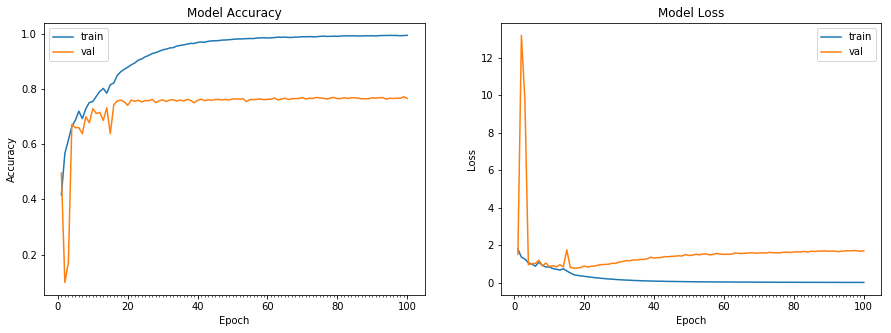

Accuracy on test data is: 76.50


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy 
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))